In [1]:
import pandas as pd 
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")
# import mitosheet

## 正片開始

In [ ]:
df = pd.read_excel(r"D:\kc.hsu\OneDrive - Bridgestone\數據\銷售數據\202201-04_raw_data.xlsx")

In [ ]:
df["營業額"] = df["銷售數量"] * df["銷貨單價"]

In [ ]:
# cus_code = pd.read_csv("../sales_related/ReferenceTable/category_types.csv")
cus_code = pd.read_excel("../sales_related/ReferenceTable/category_types.xlsx")

In [ ]:
cus_dict = dict(zip(cus_code["客戶代號"], cus_code["客戶"]))

In [ ]:
channel_dict = dict(zip(cus_code["客戶代號"], cus_code["小通路"]))

In [ ]:
area_dict = dict(zip(cus_code["客戶代號"], cus_code["區域"]))

In [ ]:
df.columns

In [ ]:
data = df.groupby(["實際出貨日", "訂單單號", "買方"])[["營業額"]].sum().reset_index()

In [ ]:
data["客戶名稱"] = data["買方"].map(cus_dict)

In [ ]:
data["通路"] = data["買方"].map(channel_dict)

In [ ]:
data["實際出貨日"] = pd.to_datetime(data["實際出貨日"])

In [ ]:
last_buy = data["實際出貨日"].max()

In [ ]:
rfmTable = data.groupby(["通路", "客戶名稱"]).agg({"實際出貨日": lambda x: (last_buy - x.max()).days, "訂單單號": lambda x: len(x), "營業額": lambda x: x.sum()})

In [ ]:
rfmTable["實際出貨日"] = rfmTable["實際出貨日"].astype(int)

In [ ]:
rfmTable.rename(columns={"實際出貨日": "recency", "訂單單號": "frequency", "營業額": "amount"}, inplace=True)

In [ ]:
rfmTable.head()

In [ ]:
data[data["客戶名稱"] == "一進汽車貨運有限公司"]

In [ ]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])

In [ ]:
quantiles

In [ ]:
quantiles = quantiles.to_dict()

In [ ]:
quantiles

In [ ]:
rfmSegmentation = rfmTable

In [ ]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [ ]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['amount'].apply(FMClass, args=('amount',quantiles,))

In [ ]:
rfmSegmentation["RFMClass"] = rfmSegmentation["R_Quartile"] + rfmSegmentation["F_Quartile"] + rfmSegmentation["M_Quartile"]

In [ ]:
bins = [1, 3, 6, 9, 12]
rfmSegmentation["客戶等級"] = pd.cut(rfmSegmentation["RFMClass"], bins, labels=["C", "B", "A", "S"])

In [ ]:
rfmSegmentation

In [ ]:
rfmSegmentation[rfmSegmentation["客戶等級"] == "S"]

In [ ]:
result = rfmSegmentation.reset_index()

In [ ]:
result.to_excel(r"C:\Users\kc.hsu\Desktop\RFM_analysis.xlsx", index=False)

In [ ]:
import plotly.express as px

In [ ]:
px.scatter_3d(rfmSegmentation, x="recency", y="amount", z="frequency", color="客戶等級", height=1080, log_y=True, log_x=True)

In [ ]:
px.scatter(rfmSegmentation, x="recency", y="frequency", size="amount", color="客戶等級", log_y=True)

## 2022 June 7th更新
### Method
1. Utilize the latest 12 months' sales record to do the customer classification.
2. Only classify BSSC customers
3. Break down into area(By the responsible territory of the BSSC branch offices)

In [36]:
df = pd.read_csv(r"D:\kc.hsu\OneDrive - Bridgestone\數據\銷售數據\2019-202205.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\kc.hsu\\OneDrive - Bridgestone\\數據\\銷售數據\\2019-202205.csv'

In [163]:
df = pd.read_pickle(r"D:\kc.hsu\OneDrive - Bridgestone\數據\銷售數據\長期銷售記錄\2017-202208.pkl")

In [164]:
df = df[(df["實際出貨日"].between("2021-01-01", "2022-06-30")) & (df["大通路"] == "BSSC")]

In [165]:
df["營業額"] = df["銷售數量"] * df["銷貨單價"]

In [166]:
data = df.groupby(["實際出貨日", "訂單單號", "買方", "客戶名稱", "大通路", "小通路",  "客戶城市"])[["銷售數量", "營業額"]].sum().reset_index()

In [167]:
data["實際出貨日"] = pd.to_datetime(data["實際出貨日"], yearfirst=True)

In [ ]:
# BSSC-FLT對照表設定
sc_flt_code = pd.read_excel("../sales_related/ReferenceTable/bssc_flt_category_types.xlsx")
cus_dict = dict(zip(sc_flt_code["客戶代號"], sc_flt_code["客戶"]))
channel_dict = dict(zip(sc_flt_code["客戶代號"], sc_flt_code["大通路"]))
area_dict = dict(zip(sc_flt_code["客戶代號"], sc_flt_code["業態"]))
city_dict = dict(zip(sc_flt_code["客戶"], sc_flt_code["區域"]))           

In [ ]:
data["客戶名稱"] = data["買方"].map(cus_dict)
data["通路"] = data["買方"].map(channel_dict)
data["區域"] = data["買方"].map(area_dict)
data["實際出貨日"] = pd.to_datetime(data["實際出貨日"])

In [ ]:
data["通路"].unique()
# BSSC-FLT條件設定
data = data[(data["通路"].isin(["BSSC-FLT"])) & (data["實際出貨日"] >= "2021-01-01")]

In [ ]:
# 條件設定
data = data[~(data["通路"].isin(["BSSC-FLT", "FLT-REP", "FLT-OE", "台灣普利司通股份有限公司", "CD", "AG"])) & (data["實際出貨日"] >= "2021-06-01")]

In [ ]:
data["區域"] = data["區域"].str.strip()
data["通路"] = data["通路"].map(lambda x: "FMC" if x == "TTC" or x == "BFP" else x)

## 客戶分類定義：
- 重要價值客戶（R高，F高，M高）
- 重要發展客戶（R高，F低，M高）
- 重要保持客戶（R低，F高，M高）
- 重要挽留客戶（R低，F低，M高）
- 一般挽留客戶（R低，F低，M低）
- 一般發展客戶（R高，F低，M低）
- 一般保持客戶（R低，F高，M低）
- 一般價值客戶（R高，F高，M低）

In [12]:
ranking_category = ["重要價值客戶", "重要發展客戶", "重要保持客戶", "重要挽留客戶", "一般挽留客戶", "一般發展客戶", "一般保持客戶", "一般價值客戶"]
ranking_value = [(1,1,1), (1,0,1), (0,1,1), (0,0,1), (0, 0, 0), (1, 0, 0), (0, 1, 0), (1, 1, 0)]
ranking_dict = dict(zip(ranking_value, ranking_category))

In [14]:
# 按照區域將各區域切出來個別分析
def region_devider(data):
    data_list = {}
    for i in data["客戶城市"].unique().tolist():
        globals()["area" + i] = data[data["客戶城市"] == i]
        data_list.setdefault(i + "_shape", globals()["area" + i])
    return data_list

In [44]:
# 按照各區域通路別切出來分析
def channel_devider(data):
    data_list = {}
    for name in data.keys():
        for i in data[name]["小通路"].unique().tolist():
            globals()[name + i + "_channel"] = data[name][data[name]["小通路"] == i]
            data_list.setdefault(name + "_" + i + "_channel", globals()[name + i + "_channel"])
    return data_list


In [45]:
# 各區數據前處理
def data_preprocessing(data):
    final_data = {}
    for i in data.keys():
        globals()[i + "_data"] = data[i].groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"]).size().reset_index()[["實際出貨日", "客戶名稱"]].drop_duplicates()
        globals()[i + "_revenue"] = data[i].groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"])[["營業額", "銷售數量"]].sum()
        globals()[i + "_final"] = globals()[i + "_data"].merge(globals()[i + "_revenue"], on=["實際出貨日", "客戶名稱"])
        globals()[i + "_final"]["小通路"] = data[i]["小通路"].unique().tolist()[0]
        final_data.setdefault(i + "_basic", globals()[i + "_final"])
    return final_data

In [168]:
# 最後購買日期
last_buy = data["實際出貨日"].max()

In [47]:
def score_calculation(data):
    sorted_data = {}
    for i in data.keys():
        globals()["rfmTable" + i] = data[i].groupby(["客戶名稱", "小通路"]).agg({"實際出貨日": lambda x: (last_buy - x.max()).days, "客戶名稱": lambda x: len(x), "營業額": lambda x: x.sum(), "銷售數量": lambda x: x.sum()})
        globals()["rfmTable" + i]["實際出貨日"] = globals()["rfmTable" + i]["實際出貨日"].astype(int)
        globals()["rfmTable" + i].rename(columns={"實際出貨日": "recency", "客戶名稱": "frequency", "營業額": "amount", "銷售數量": "volume"}, inplace=True)
        sorted_data.setdefault(i + "_sorted", globals()["rfmTable" + i])
    return sorted_data

In [62]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.7]:
        return 1
    else:
        return 0
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x < d[p][0.7]:
        return 0
    else:
        return 1
    
# Arguments (x = value, p = frequency)
def FreClass(x):
    # if x < 8:
    if x < 9:
        return 0
    else: 
        return 1
        
    

In [49]:
def quartile_calculation(data):
    sorted_data = {}
    for i in data.keys():
        globals()["quantiles" + i] = data[i].quantile(q=[0.7])
        globals()["quantiles" + i] = globals()["quantiles" + i].to_dict()
        data[i]["R_Quartile"] = data[i]["recency"].apply(RClass, args=("recency", globals()["quantiles" + i],))
        data[i]["F_Quartile"] = data[i]["frequency"].apply(FreClass)
        data[i]["M_Quartile"] = data[i]["amount"].apply(FMClass, args=("amount", globals()["quantiles" + i],))
        data[i]["Score"] = data[i][["R_Quartile", "F_Quartile", "M_Quartile"]].apply(tuple, axis=1)
        data[i]["客戶等級"] = data[i]["Score"].map(ranking_dict)
        data[i].reset_index(inplace=True)
        sorted_data.setdefault(i + "_final", data[i])
    return sorted_data       

In [50]:
def combine_data(data):
    sorted_data = {}
    for i in data.keys():
        data[i]["客戶城市"] = i[:2]
        sorted_data.setdefault(i + "rfm_model", data[i])
    return sorted_data     
        
    

## 更換邏輯，用每一區來作為計算比重

In [ ]:
def data_preprocessing_2(data):
    final_data = {}
    for i in data.keys():
        chan_dict = dict(zip(data[i]["客戶名稱"], data[i]["通路"]))
        globals()[i + "_data"] = data[i].groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"]).size().reset_index()[["實際出貨日", "客戶名稱"]].drop_duplicates()
        globals()[i + "_revenue"] = data[i].groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"])[["營業額", "銷售數量"]].sum()
        globals()[i + "_final"] = globals()[i + "_data"].merge(globals()[i + "_revenue"], on=["實際出貨日", "客戶名稱"])
        globals()[i + "_final"]["通路"] = globals()[i + "_final"]["客戶名稱"].map(chan_dict)
        final_data.setdefault(i + "_basic", globals()[i + "_final"])
    return final_data

In [ ]:
regions = region_devider(data)
# channels = channel_devider(regions)
filtered_data = data_preprocessing_2(regions)
calculated_data = score_calculation(filtered_data)
result = quartile_calculation(calculated_data)
combined_data = combine_data(result)
final_result = pd.concat(result.values())
# final_result.to_excel(r"C:\Users\kc.hsu\Desktop\區域別_rfm_model_v2.xlsx", index=False)
# final_result.to_excel(r"C:\Users\kc.hsu\Desktop\bssc_flt_rfm_model_v2.xlsx", index=False)

In [ ]:
final_result["營業所"] = final_result["客戶名稱"].map(city_dict)
final_result.to_excel(r"C:\Users\kc.hsu\Desktop\bssc_flt_rfm_model_v2.xlsx", index=False)

## 回到原文

In [169]:
regions = region_devider(data)
channels = channel_devider(regions)
filtered_data = data_preprocessing(channels)
calculated_data = score_calculation(filtered_data)
result = quartile_calculation(calculated_data)
combined_data = combine_data(result)
final_result = pd.concat(result.values())


In [170]:
final_result["月平均"] = final_result["volume"] / 18

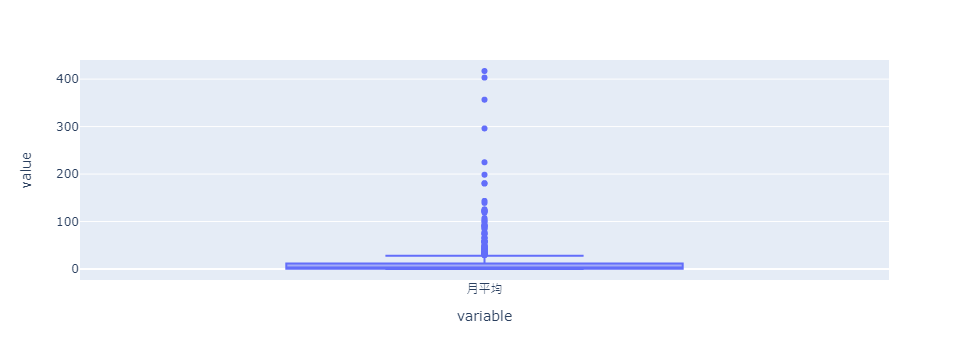

In [171]:
import plotly.express as px
px.box(final_result["月平均"])

In [172]:
final_result["離群值"] = final_result["月平均"].map(lambda x: "Yes" if x > 27.89 else "No")

In [173]:
final_result["離群值"].value_counts()

No     391
Yes     72
Name: 離群值, dtype: int64

In [174]:
final_result.groupby(["離群值"])[["volume"]].sum()

,volume
離群值,
No,31149
Yes,114950


In [175]:
final_result[final_result["離群值"] == "Yes"]["月平均"].quantile([0.2, 0.5, 0.85])

0.20     35.322222
0.50     58.416667
0.85    124.313889
Name: 月平均, dtype: float64

In [176]:
bins = [0, 35, 60, 125, 1000]
labels = ["No contract", "B", "A", "S"]
final_result["客戶推定等級"] = pd.cut(final_result["月平均"], bins=bins, labels=labels)

In [178]:
signboard = pd.read_excel(r"D:\kc.hsu\OneDrive - Bridgestone\行銷推廣\掛牌店\2022年FMC店數.xlsx", sheet_name="工作表1")

In [179]:
signboard.columns = ['編號', '營業所', '客戶代號', '通路', '客戶簡稱', '月均需求(BS,MI,MA)', '月均需求(所有品牌)',
       'BS signboard', 'BS招牌安裝日', '是否有意願裝BS招牌', 'MI合約到期日', '是否簽附加合約', '簽約等級',
       '2021年銷售量', '2022年銷售量', 'Growth rate', '是否保留']

In [180]:
signboard_dict = dict(zip(signboard["客戶簡稱"], signboard["BS signboard"]))

In [181]:
final_result["FMC"] = final_result["客戶名稱"].map(signboard_dict).fillna("No")

In [190]:
final_result["談約排序"] = final_result.apply(lambda x: "最優先" if x["客戶推定等級"] != "No contract" and x["FMC"] != "No" else "優先" if x["客戶推定等級"] != "No contract" and x["FMC"] == "No" else "優先確認意向" if x["客戶推定等級"] == "No contract" and x["FMC"] != "No" else "一般", axis=1)

In [191]:
final_result.to_excel(r"C:\Users\kc.hsu\Desktop\20221206_rfm_model.xlsx", index=False)

## 2019年~2022年4月銷售實績RFM模型建立
- 使用K-Means演算法分群
- 每個月的頻率只用有無下單來累計，因為有的客戶每月下很多小單，但大客戶一個月只下一張單，這樣Frequency的分數會被影響到，需排除這個問題

### 使用手動分群4群和使用K-means來找出最適合的群組

In [ ]:
df = pd.read_excel(r"D:\kc.hsu\OneDrive - Bridgestone\數據\銷售數據\2019-202204.xlsx")

In [ ]:
df["營業額"] = df["銷售數量"] * df["銷貨單價"]

In [ ]:
data = df.groupby(["實際出貨日", "訂單單號", "買方"])[["銷售數量", "營業額"]].sum().reset_index()

In [ ]:
data["客戶名稱"] = data["買方"].map(cus_dict)
data["通路"] = data["買方"].map(channel_dict)
data["實際出貨日"] = pd.to_datetime(data["實際出貨日"])

In [ ]:
data = data[data["通路"] == "BSSC"]

In [ ]:
test_1 = data.groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"]).size().reset_index()[["實際出貨日", "客戶名稱"]].drop_duplicates()

In [ ]:
test_1

In [ ]:
test_2 = data.groupby([pd.Grouper(key="實際出貨日", freq="M"), "客戶名稱"])[["營業額", "銷售數量"]].sum()

In [ ]:
test_3 = test_1.merge(test_2, on=["實際出貨日", "客戶名稱"])

In [ ]:
last_buy = data["實際出貨日"].max()

In [ ]:
rfmTable = test_3.groupby(["客戶名稱"]).agg({"實際出貨日": lambda x: (last_buy - x.max()).days, "客戶名稱": lambda x: len(x), "營業額": lambda x: x.sum(), "銷售數量": lambda x: x.sum()})

In [ ]:
# rfmTable = data.groupby(["通路", "客戶名稱"]).agg({"實際出貨日": lambda x: (last_buy - x.max()).days, "訂單單號": lambda x: len(x), "營業額": lambda x: x.sum(), "銷售數量": lambda x: x.sum()})

In [ ]:
# rfmTable.rename(columns={"實際出貨日": "recency", "訂單單號": "frequency", "營業額": "amount", "銷售數量": "volume"}, inplace=True)

In [ ]:
rfmTable["實際出貨日"] = rfmTable["實際出貨日"].astype(int)

In [ ]:
rfmTable.rename(columns={"實際出貨日": "recency", "客戶名稱": "frequency", "營業額": "amount", "銷售數量": "volume"}, inplace=True)

### 數據前處理後為四個欄位
1. Recency(代表客戶最後一次購買距離數據裡面最後面的日期4/30)
2. Frequncy(代表客戶購買頻率，扣除掉前面的說明，就是客戶40個月的區間有幾個月有下過訂單)
3. Amount(代表客戶在數據區間中累計的營業額貢獻)
4. Volume(代表客戶在數據區間中累計的條數）

In [ ]:
rfmTable

In [ ]:
quantiles = rfmTable.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()

### 按照每個特徵值的20%，40%，60%，80%的值來做區間分佈

In [ ]:
quantiles

In [ ]:
rfmSegmentation = rfmTable.copy()

In [ ]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <=d[p][0.8]:
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]:
        return 4
    else:
        return 5

In [ ]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['amount'].apply(FMClass, args=('amount',quantiles,))
rfmSegmentation["V_Quartile"] = rfmSegmentation["volume"].apply(FMClass, args=("volume", quantiles,))

In [ ]:
rfmSegmentation

In [ ]:
rfmSegmentation["RFMClass"] = rfmSegmentation["R_Quartile"] + rfmSegmentation["F_Quartile"] + rfmSegmentation["M_Quartile"] + rfmSegmentation["V_Quartile"]

In [ ]:
bins = [3, 8, 12, 16, 20]
rfmSegmentation["客戶等級"] = pd.cut(rfmSegmentation["RFMClass"], bins, labels=["C", "B", "A", "S"])

In [ ]:
### 將客戶手動分為4個群組

In [ ]:
rfmSegmentation

## K-means分群

In [ ]:
rfmSegmentation_k = rfmSegmentation.copy().reset_index()

In [ ]:
rfmSegmentation_k

In [ ]:
sc_customers = rfmSegmentation_k

In [ ]:
sc_customers = sc_customers[["客戶名稱", "R_Quartile", "F_Quartile", "M_Quartile", "V_Quartile"]]

In [ ]:
sc_customers

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
test = sc_customers.drop(sc_customers.columns[0], axis=1)

In [ ]:
wcss = []
for i in range(1,30):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(test)
    wcss.append(kmeans.inertia_)

## 損失函數圖

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.plot(range(1,30), wcss, marker='o')
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

## 以損失函數來看分8群左右就已經基本可以反應了

In [ ]:
kmeans = KMeans(n_clusters=8, init='k-means++', random_state=0)
sc_customers_2=sc_customers.drop(sc_customers.columns[0], axis=1)
sc_customers['clusters'] = kmeans.fit_predict(sc_customers_2)
sc_customers.tail(10)

In [ ]:
sc_customers_2.head(10)

## 檢查最佳的是在第幾群，可以看出最佳在第二群

In [ ]:
round(pd.DataFrame(kmeans.cluster_centers_),2)

In [ ]:
kmeans_result = round(pd.DataFrame(kmeans.cluster_centers_),2)

In [ ]:
kmeans_result["score"] = kmeans_result.sum(axis=1)

In [ ]:
kmeans_result

In [ ]:
kmeans_rank_dict = {2: "VIP", 4: "S", 6: "A", 0: "B", 7: "C", 3: "D", 5: "E", 1: "F"}

In [ ]:
sc_customers["客戶等級"] = sc_customers["clusters"].map(kmeans_rank_dict)

In [ ]:
cluster_result = sc_customers

In [ ]:
cluster_result

In [ ]:
rfmSegmentation_k.columns

In [ ]:
final_result = sc_customers.merge(rfmSegmentation_k, on=['客戶名稱', 'R_Quartile', 'F_Quartile', 'M_Quartile', 'V_Quartile'])

In [ ]:
final_result.to_excel(r"C:\Users\kc.hsu\Desktop\kmeans_rfm_model.xlsx", index=False)

In [ ]:
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode()

In [ ]:
k_means_plot = px.scatter_3d(final_result, x="recency", y="amount", z="frequency", color="客戶等級_x", log_y=True, log_x=True, height=1080, title="K-means分群", hover_data=["客戶名稱"])
k_means_plot.show()

In [ ]:
manual_cluster_plot = px.scatter_3d(final_result, x="recency", y="amount", z="frequency", color="客戶等級_y", log_y=True, log_x=True, height=1080, title="人工分群")
manual_cluster_plot.show()